In [1]:
import pandas as pd

def load_weekly_sales(path):
    
    df = pd.read_csv(path)
    df['week_start'] = pd.to_datetime(df['week_start'])
    weekly_sales = df.groupby('week_start')['Sum of Invoiced Amount EUR'].sum().asfreq('W-MON')

    return weekly_sales.fillna(0)

In [2]:
def split_series_by_date(series, cutoff):

    series.index = pd.to_datetime(series.index)
    cutoff = pd.to_datetime(cutoff)
    
    train = series[series.index < cutoff]
    test = series[series.index >= cutoff]
 
    return train, test


In [3]:
import matplotlib.pyplot as plt

    # Visual check for trends, seasonality, or anomalies
def plot_series(series, title="Weekly Total Sales (EUR)"):
    
    series.plot(figsize=(12, 4), title=title)
    plt.ylabel("Sales (€)")
    plt.xlabel("Week Start")
    plt.show()

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")


In [5]:
import matplotlib.pyplot as plt

def difference_series(series, seasonal_lag=4):
    # First differencing to remove trend
    diff = series.diff().dropna()
    # Seasonal differencing to address weekly seasonality
    diff_seasonal = diff.diff(seasonal_lag).dropna()
    return diff_seasonal

def plot_differenced_series(series, title="First + Seasonal Differenced Series"):
    series.plot(figsize=(12, 4), title=title)
    plt.show()


In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_acf_pacf(series, lags=30):
    # ACF shows correlation with past lags; PACF shows direct influence of past values
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title('ACF (Differenced Series)')

    plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title('PACF (Differenced Series)')

    plt.tight_layout()
    plt.show()



In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_sarima(series, order=(1, 1, 1), seasonal_order=(1, 1, 0, 4)):
    # Fit SARIMA model with specified parameters
    model = SARIMAX(
        series,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit()
    return results


In [9]:
import matplotlib.pyplot as plt

def forecast_and_plot(model_results, original_series, steps=12, title="12-Week Sales Forecast (SARIMA)"):
    forecast = model_results.get_forecast(steps=steps)
    mean_forecast = forecast.predicted_mean
    conf_int = forecast.conf_int()

    plt.figure(figsize=(12, 5))
    plt.plot(original_series, label='Observed')
    plt.plot(mean_forecast, label='Forecast', color='red')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.show()
    
    return mean_forecast, conf_int


In [10]:
def forecast_from_model(model_results, steps):
    forecast = model_results.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    return forecast_mean, conf_int


In [11]:
import matplotlib.pyplot as plt

def plot_forecast_vs_actual(train, test, forecast, conf_int, title="SARIMA Forecast"):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Training')
    plt.plot(test, label='Actual', color='green')
    plt.plot(forecast, label='Forecast', color='red')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(title)
    plt.legend()
    plt.show()


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    return mae, rmse



In [13]:
def compare_advanced_sarima_models(train, test, model_configs):
    forecasts = {}
    for label, (order, seasonal_order) in model_configs.items():
        model = SARIMAX(
            train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        forecast = results.get_forecast(steps=len(test))
        forecasts[label] = forecast.predicted_mean
    return forecasts


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def compare_sarima_models(train, test, model_configs):
    forecasts = {}
    for label, (p, d, q, P, D, Q, s) in model_configs.items():
        model = SARIMAX(
            train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        forecast = results.get_forecast(steps=len(test))
        forecasts[label] = forecast.predicted_mean
    return forecasts


In [15]:

import matplotlib.pyplot as plt

def plot_model_comparisons(train, test, forecasts, title="SARIMA Forecasts: Varying Seasonality"):
    plt.figure(figsize=(14, 6))
    plt.plot(train, label='Training')
    plt.plot(test, label='Actual', color='green')

    for label, forecast in forecasts.items():
        plt.plot(forecast, label=f'Forecast - {label}')

    plt.title(title)
    plt.legend()
    plt.show()

In [16]:
import matplotlib.pyplot as plt

def plot_forecast_panels(train, test, forecasts, since_date='2024-03-01', title="SARIMA Forecast Comparison"):
    recent_train = train[train.index >= since_date]
    fig, axes = plt.subplots(len(forecasts), 1, figsize=(14, 12), sharex=True)

    for i, (label, forecast) in enumerate(forecasts.items()):
        ax = axes[i]
        ax.plot(recent_train, label='Training (last 6mo)', color='blue')
        ax.plot(test, label='Actual', color='green')
        ax.plot(forecast, label=f'Forecast - {label}', color='red')
        ax.set_title(label)
        ax.legend(loc='upper left')

    plt.suptitle(title + " (Sep–Dec 2024)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_multiple_forecasts(test_series, forecasts):
    metrics = {}
    for label, forecast in forecasts.items():
        y_true = test_series.loc[forecast.index]
        y_pred = forecast.loc[test_series.index]

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)

        metrics[label] = {'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape}

    return pd.DataFrame(metrics).T.sort_values(by='RMSE')


In [18]:
def scale_forecast_to_actual(forecast, actual):
    # Align forecast with actuals to avoid index mismatch
    actual_aligned = actual.loc[forecast.index]
    scaling_factor = actual_aligned.mean() / forecast.mean()

    print(f"Scaling factor: {scaling_factor:.3f}")

    scaled_forecast = forecast * scaling_factor
    
    return scaled_forecast, scaling_factor


In [19]:
import matplotlib.pyplot as plt

def plot_scaled_vs_original(test, original_forecast, scaled_forecast, title="Scaled Forecast vs Original vs Actual"):
    plt.figure(figsize=(12, 5))
    plt.plot(test, label='Actual', color='green')
    plt.plot(original_forecast, label='Original Forecast', color='red', linestyle='--')
    plt.plot(scaled_forecast, label='Scaled Forecast', color='orange')
    plt.title(title)
    plt.legend()
    plt.show()



In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_scaled_forecast(y_true, forecast):
    mae = mean_absolute_error(y_true, forecast)
    rmse = np.sqrt(mean_squared_error(y_true, forecast))
    mape = np.mean(np.abs((y_true - forecast) / y_true)) * 100

    print(f"Scaled MAE: {mae:,.2f}")
    print(f"Scaled RMSE: {rmse:,.2f}")
    print(f"Scaled MAPE: {mape:.2f}%")
    
    return mae, rmse, mape


In [21]:
import numpy as np
import pandas as pd

def apply_progressive_scaling(forecast, final_scaling_factor):
    n_steps = len(forecast)
    # Linearly interpolate from 1.0 to the final scaling factor
    progressive_factors = np.linspace(1.0, final_scaling_factor, n_steps)
    progressively_scaled = forecast.values * progressive_factors
    return pd.Series(progressively_scaled, index=forecast.index)


In [22]:
import matplotlib.pyplot as plt

def plot_progressive_scaled_forecast(test, original_forecast, progressive_scaled, title="Progressive Scaling Forecast vs Actual"):
    plt.figure(figsize=(12, 5))
    plt.plot(test, label='Actual', color='green')
    plt.plot(original_forecast, label='Original Forecast', linestyle='--', color='red')
    plt.plot(progressive_scaled, label='Progressive Scaled Forecast', color='orange')
    plt.title(title)
    plt.legend()
    plt.show()



In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_progressive_forecast(y_true, forecast):
    mae = mean_absolute_error(y_true, forecast)
    rmse = np.sqrt(mean_squared_error(y_true, forecast))
    mape = np.mean(np.abs((y_true - forecast) / y_true)) * 100

    print(f"Progressive MAE: {mae:,.2f}")
    print(f"Progressive RMSE: {rmse:,.2f}")
    print(f"Progressive MAPE: {mape:.2f}%")
    
    return mae, rmse, mape


Check for overfitting

In [24]:
import pandas as pd

def split_series_custom_range(series, train_end, test_end):
    train_end = pd.to_datetime(train_end)
    test_end = pd.to_datetime(test_end)

    train = series[series.index < train_end]
    test = series[(series.index >= train_end) & (series.index <= test_end)]
    
    return train, test



C:\Users\danii\AppData\Local\Temp\ipykernel_20472\2772212342.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Data loaded and processed successfully


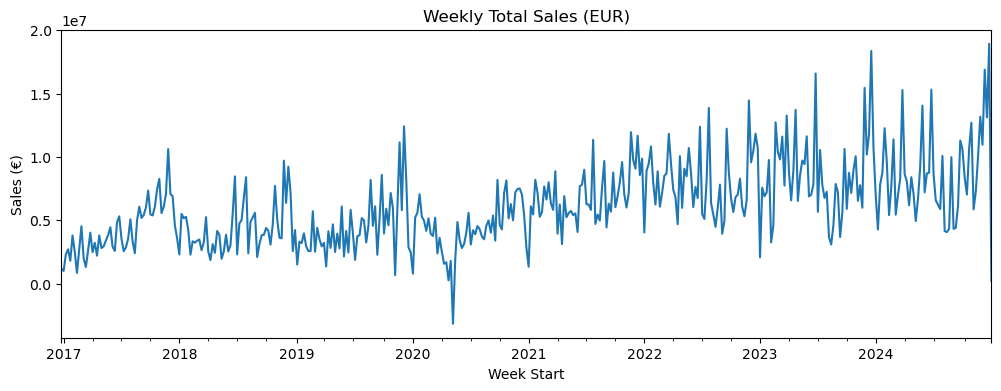

ADF Statistic: -1.9339
p-value: 0.3163


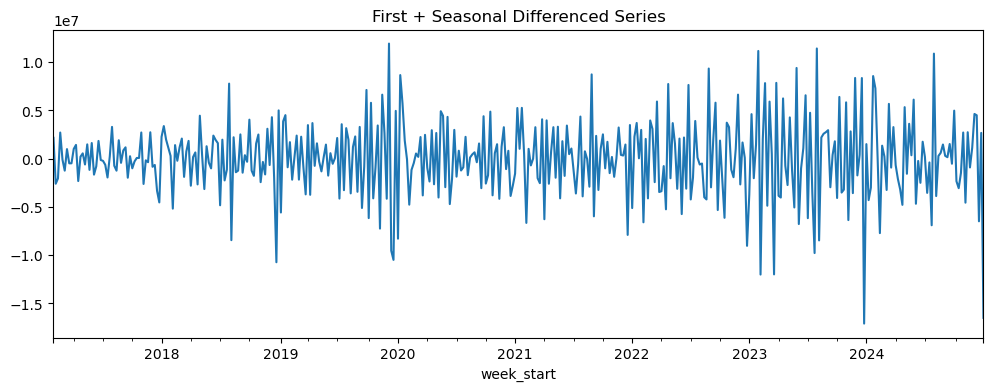

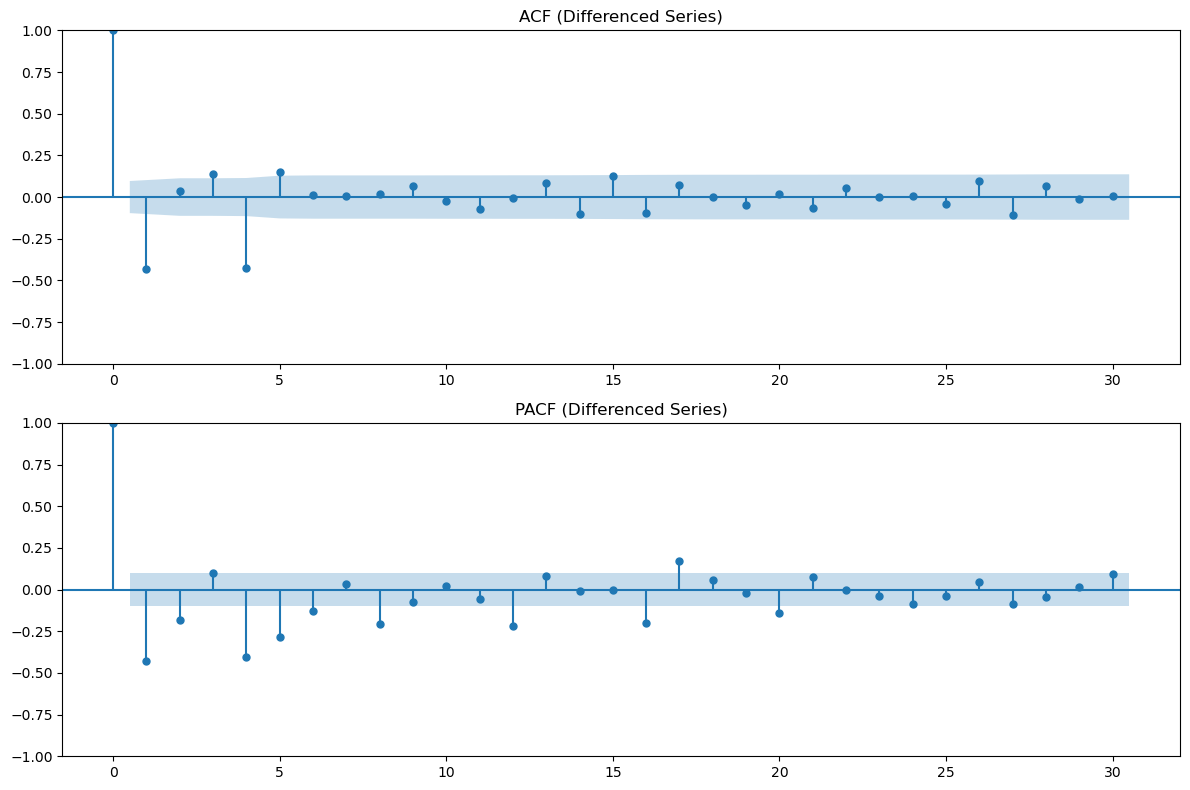

                                     SARIMAX Results                                      
Dep. Variable:         Sum of Invoiced Amount EUR   No. Observations:                  419
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 4)   Log Likelihood               -6670.936
Date:                            Tue, 13 May 2025   AIC                          13349.873
Time:                                    20:42:38   BIC                          13365.928
Sample:                                12-26-2016   HQIC                         13356.225
                                     - 12-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1731      0.074      2.344      0.019       0.028       0.318
ma.L1         -0.9893      0.015   

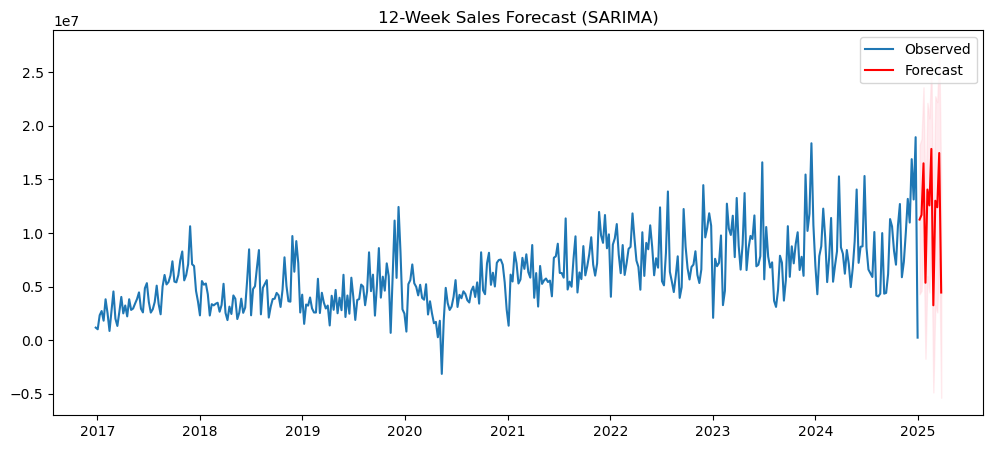

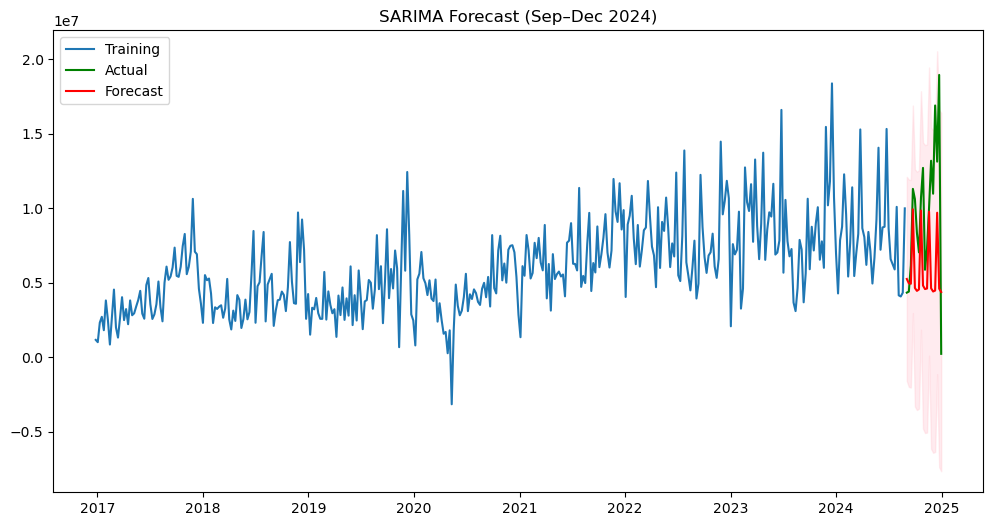

MAE: 4380872.05
RMSE: 5956135.71


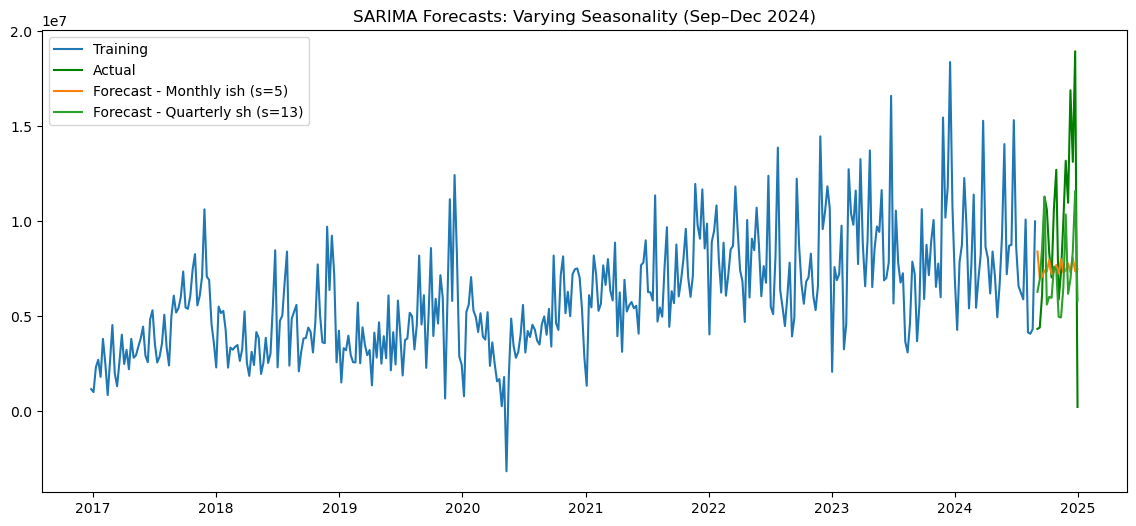

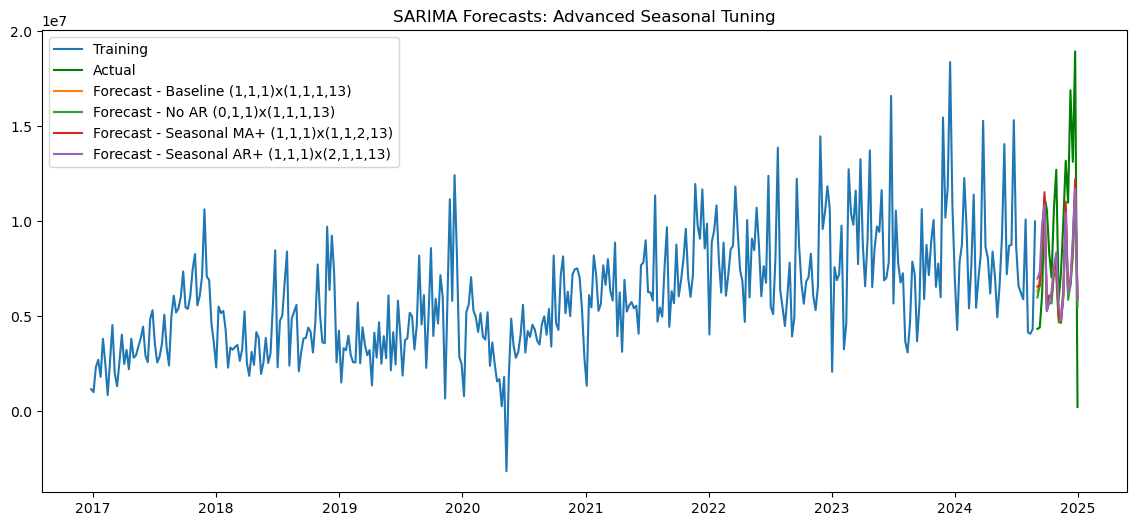

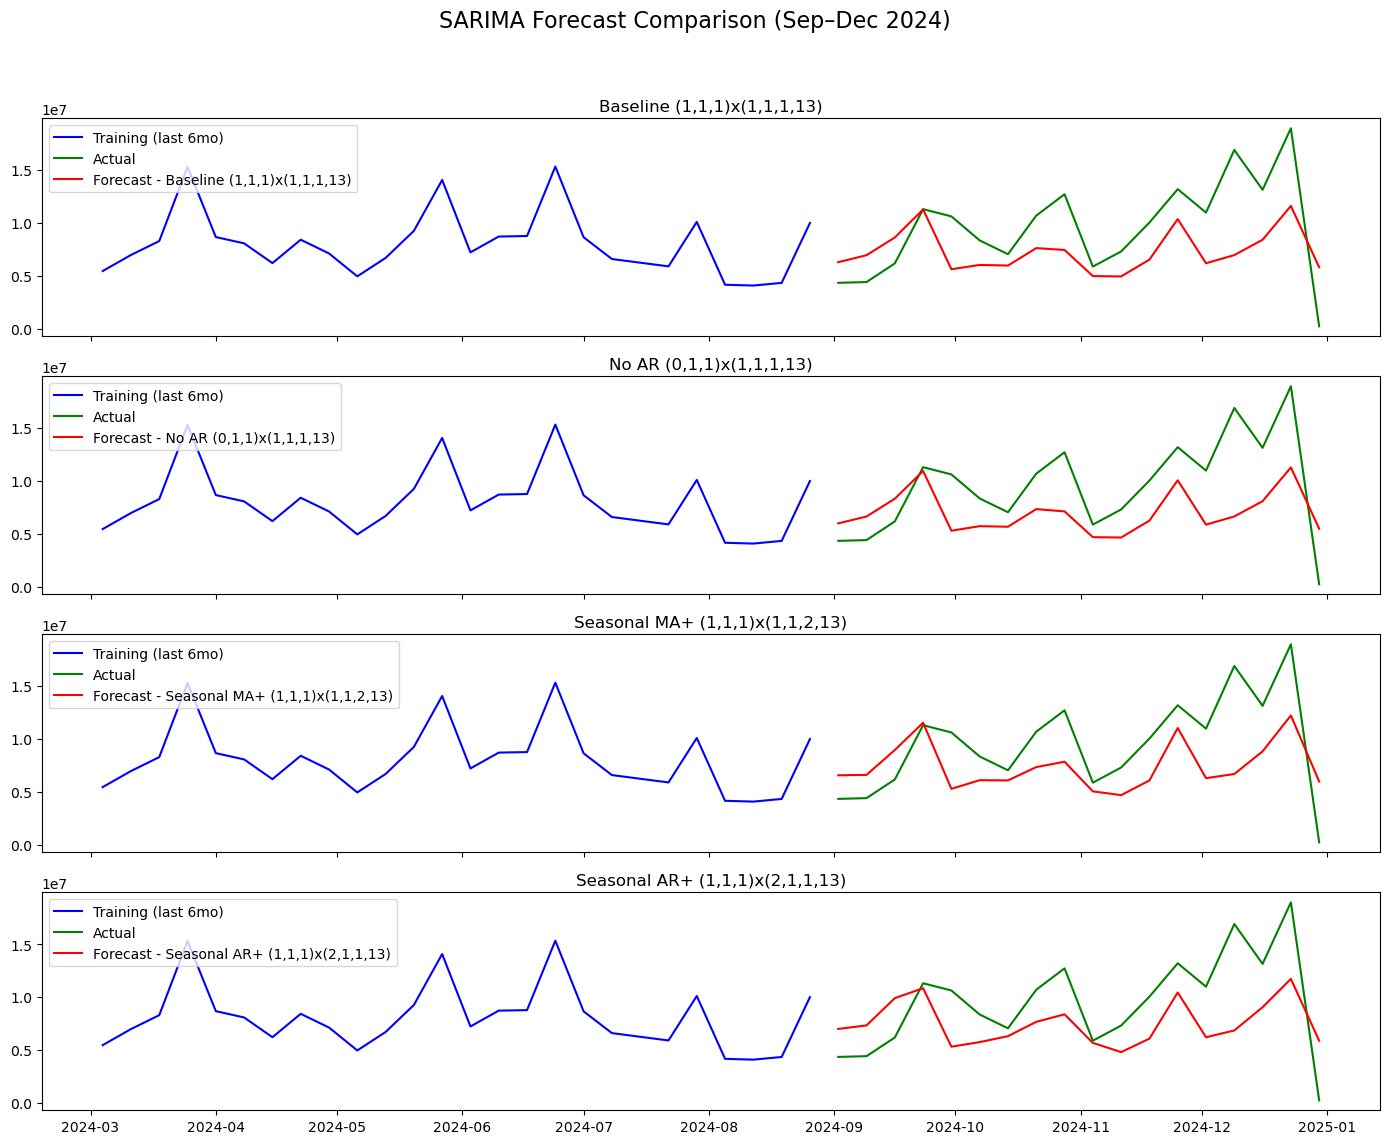

                                          MAE          RMSE    MAPE (%)
Seasonal MA+ (1,1,1)x(1,1,2,13)  3.632276e+06  4.329652e+06  174.212475
Baseline (1,1,1)x(1,1,1,13)      3.646747e+06  4.349365e+06  169.845681
Seasonal AR+ (1,1,1)x(2,1,1,13)  3.723875e+06  4.395139e+06  173.192465
No AR (0,1,1)x(1,1,1,13)         3.816996e+06  4.518240e+06  163.219759
Scaling factor: 1.293


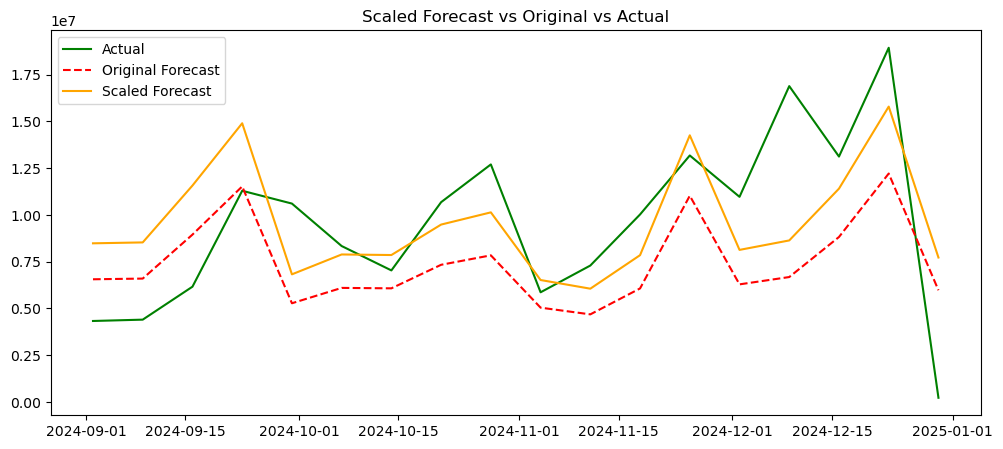

Scaled MAE: 3,039,477.88
Scaled RMSE: 3,747,751.23
Scaled MAPE: 215.69%


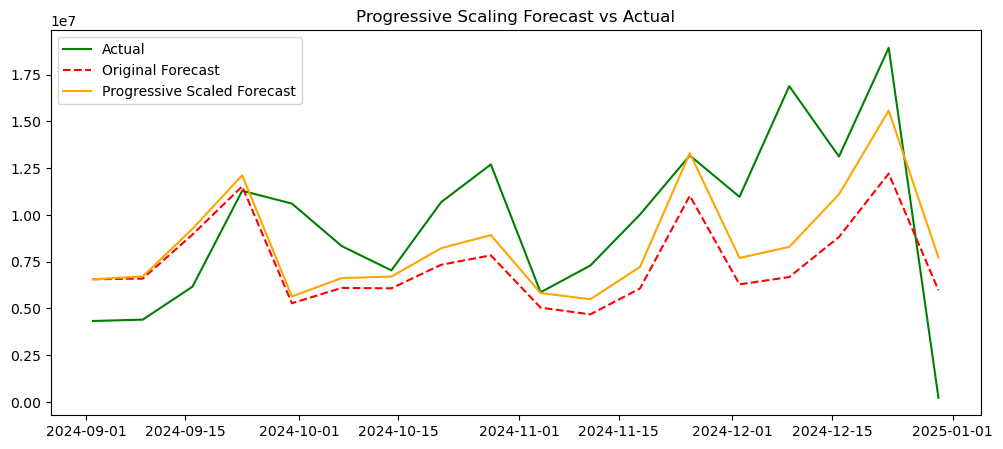

Progressive MAE: 2,845,872.38
Progressive RMSE: 3,620,279.08
Progressive MAPE: 210.05%


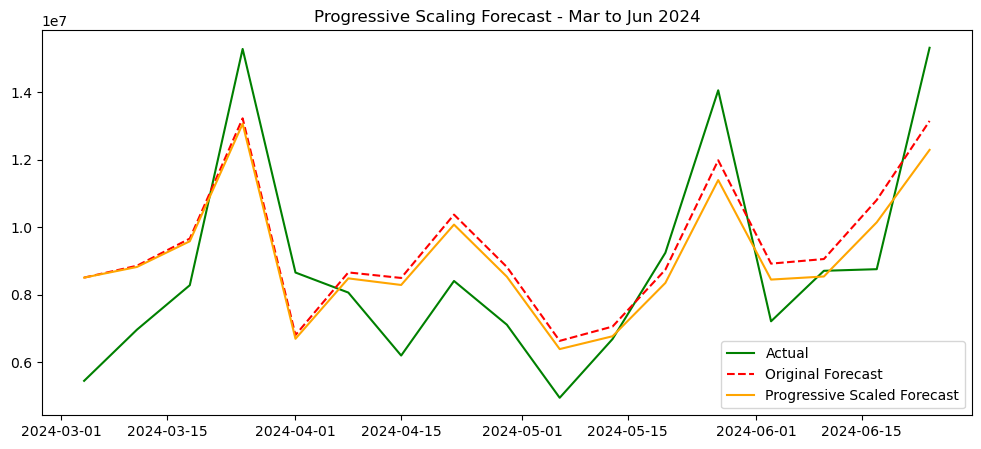

Progressive MAE: 1,582,937.19
Progressive RMSE: 1,803,170.38
Progressive MAPE: 19.32%


(1582937.1898282003, 1803170.3808190369, 19.32116224177677)

In [25]:
# 1. Load weekly sales data
weekly_sales = load_weekly_sales("Working_df/Actuals_all_enriched.csv")
print("Data loaded and processed successfully")

# 2. Split into train/test (Sep–Dec as test)
train_series, test_series = split_series_by_date(weekly_sales, "2024-09-01")

# 3. Plot and stationarity test
plot_series(weekly_sales)
adf_test(weekly_sales)

# 4. Differencing for seasonality insight
diff_1_seasonal = difference_series(weekly_sales, seasonal_lag=4)
plot_differenced_series(diff_1_seasonal)

# 5. ACF & PACF to guide model selection
plot_acf_pacf(diff_1_seasonal, lags=30)

# 6. Fit SARIMA model
sarima_results = fit_sarima(weekly_sales, order=(1, 1, 1), seasonal_order=(1, 1, 0, 4))
print(sarima_results.summary())

# 7. Forecast 12 weeks ahead
mean_forecast, conf_int = forecast_and_plot(sarima_results, weekly_sales, steps=12)

# 8. Train SARIMA only on train_series
sarima_train_results = fit_sarima(train_series, order=(1, 1, 1), seasonal_order=(1, 1, 0, 4))

# 9. Forecast using train model
n_test_steps = len(test_series)
forecast_mean, conf_int = forecast_from_model(sarima_train_results, steps=n_test_steps)

# 10. Plot forecast vs actual
plot_forecast_vs_actual(train_series, test_series, forecast_mean, conf_int, title="SARIMA Forecast (Sep–Dec 2024)")

# 11. Evaluate model
mae, rmse = evaluate_forecast(test_series, forecast_mean)

# 12. Compare seasonal periods
seasonal_configs = {
    "Monthly ish (s=5)": (1, 1, 1, 1, 1, 1, 5),
    "Quarterly sh (s=13)": (1, 1, 1, 1, 1, 1, 13)
}
seasonal_forecasts = compare_sarima_models(train_series, test_series, seasonal_configs)
plot_model_comparisons(train_series, test_series, seasonal_forecasts, title="SARIMA Forecasts: Varying Seasonality (Sep–Dec 2024)")

# 13. Compare advanced seasonal tuning
advanced_configs = {
    "Baseline (1,1,1)x(1,1,1,13)": ((1,1,1), (1,1,1,13)),
    "No AR (0,1,1)x(1,1,1,13)": ((0,1,1), (1,1,1,13)),
    "Seasonal MA+ (1,1,1)x(1,1,2,13)": ((1,1,1), (1,1,2,13)),
    "Seasonal AR+ (1,1,1)x(2,1,1,13)": ((1,1,1), (2,1,1,13)),
}
forecasts = compare_advanced_sarima_models(train_series, test_series, advanced_configs)
plot_model_comparisons(train_series, test_series, forecasts, title="SARIMA Forecasts: Advanced Seasonal Tuning")

# 14. Panel plots (last 6mo train only)
plot_forecast_panels(train_series, test_series, forecasts, since_date='2024-03-01')

# 15. Evaluate all models
metrics_df = evaluate_multiple_forecasts(test_series, forecasts)
print(metrics_df)

# 16. Apply scaling to best forecast
best_forecast = forecasts["Seasonal MA+ (1,1,1)x(1,1,2,13)"]
y_true = test_series.loc[best_forecast.index]
scaled_forecast, scaling_factor = scale_forecast_to_actual(best_forecast, y_true)

# 17. Plot scaled vs original vs actual
plot_scaled_vs_original(test_series, best_forecast, scaled_forecast)

# 18. Evaluate scaled forecast
evaluate_scaled_forecast(y_true, scaled_forecast)

# 19. Progressive scaling
progressively_scaled_forecast = apply_progressive_scaling(best_forecast, scaling_factor)

# 20. Plot progressive scaling forecast
plot_progressive_scaled_forecast(test_series, best_forecast, progressively_scaled_forecast)

# 21. Evaluate progressive scaling forecast
evaluate_progressive_forecast(test_series, progressively_scaled_forecast)

# 22. Early-2024 backtest split
train_early, test_early = split_series_custom_range(weekly_sales, "2024-03-01", "2024-06-30")

# 23. Fit model on early data
results_sarima = fit_sarima(train_early, order=(1,1,1), seasonal_order=(1,1,2,13))
forecast_early = forecast_from_model(results_sarima, steps=len(test_early))[0]

# 24. Scale early forecast
scaling_factor_early = test_early.mean() / forecast_early.mean()
scaled_forecast_early = apply_progressive_scaling(forecast_early, scaling_factor_early)

# 25. Plot early forecast
plot_progressive_scaled_forecast(test_early, forecast_early, scaled_forecast_early, title="Progressive Scaling Forecast - Mar to Jun 2024")

# 26. Evaluate early scaled forecast
evaluate_progressive_forecast(test_early, scaled_forecast_early)


Residuals for LSTM

In [ ]:
def compute_sarima_residuals(full_series, sarima_model):
    forecast = sarima_model.get_prediction(start=full_series.index[0], end=full_series.index[-1]).predicted_mean
    aligned_actual = full_series.loc[forecast.index]
    residuals = aligned_actual - forecast
    return forecast, residuals


NameError: name 'results' is not defined

In [ ]:
def save_residuals(residuals, path):
    residuals.to_csv(path, index=True, header=True)


In [ ]:
import pandas as pd

def load_residuals(path):
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    return df.rename(columns={df.columns[0]: "Residuals"})


In [ ]:
import pandas as pd

def load_weekly_budget(path):
    df = pd.read_csv(path, parse_dates=['Date'])
    df['week_start'] = df['Date'] - pd.to_timedelta(df['Date'].dt.weekday, unit='d')
    weekly = df.groupby('week_start').agg({
        'Sum of Invoiced Amount EUR': 'sum',
        'Sum of Invoiced Qty': 'sum'
    }).rename(columns={
        'Sum of Invoiced Amount EUR': 'budget_amount_eur',
        'Sum of Invoiced Qty': 'budget_qty'
    }).asfreq('W-MON').fillna(0)
    return weekly



C:\Users\danii\AppData\Local\Temp\ipykernel_16888\545348287.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  budget_df = pd.read_csv('Working_df/Budget_all.csv', parse_dates=['Date'])


In [ ]:
def create_weekly_features(df, residuals):
    df['week_start'] = pd.to_datetime(df['week_start'])
    
    weekly = df.groupby('week_start').agg({
        'Sum of Invoiced Amount EUR': 'sum',
        'is_expected_renewal_week': 'max',
        'is_sub_renewal': 'sum',
        'weeks_since_last_renewal': 'mean',
    }).asfreq('W-MON').fillna(0)

    weekly['residual'] = residuals
    return weekly


In [ ]:
def add_residual_lags(df, base_col='residual', lags=[1, 2, 3]):
    for lag in lags:
        df[f'{base_col}_lag_{lag}'] = df[base_col].shift(lag)
    return df


<Figure size 1400x400 with 0 Axes>

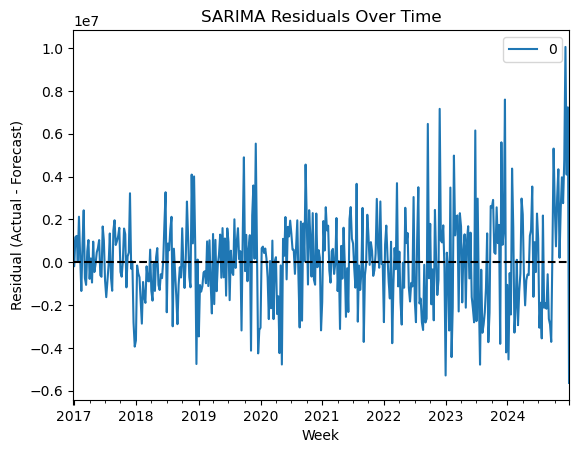

In [ ]:
import matplotlib.pyplot as plt

def plot_residual_series(residuals, title="SARIMA Residuals Over Time"):
    plt.figure(figsize=(14, 4))
    residuals.plot()
    plt.title(title)
    plt.xlabel("Week")
    plt.ylabel("Residual (Actual - Forecast)")
    plt.axhline(0, color='black', linestyle='--')
    plt.show()


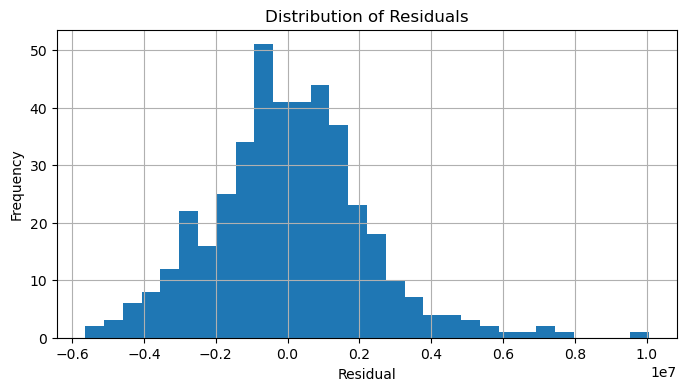

In [ ]:
import matplotlib.pyplot as plt

def plot_residual_distribution(residuals, bins=30):
    residuals.hist(bins=bins, figsize=(8, 4))
    plt.title("Distribution of Residuals")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()


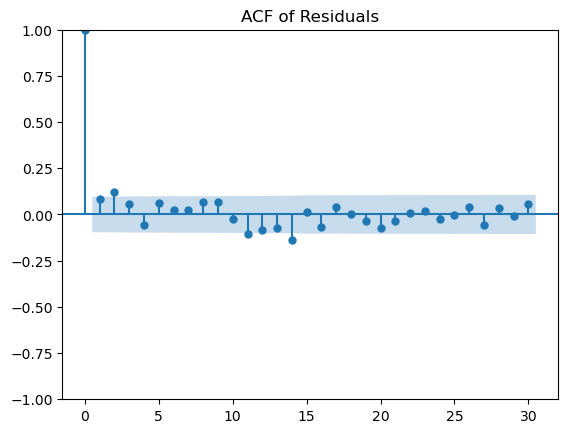

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

def plot_residual_acf(residuals, lags=30):
    plot_acf(residuals.dropna(), lags=lags)
    plt.title("ACF of Residuals")
    plt.show()


In [ ]:
import pandas as pd

def load_weekly_competitor_features(path, date_col='Date'):
    df = pd.read_csv(path, parse_dates=[date_col])
    return df.set_index(date_col).asfreq('W-MON')


In [ ]:
def create_weekly_calendar_features(df):
    df['week_start'] = pd.to_datetime(df['week_start'])
    df['month'] = df['week_start'].dt.month
    df['quarter'] = df['week_start'].dt.quarter
    df['is_year_end'] = (df['week'] >= 50).astype(int)

    weekly = df.groupby('week_start').agg({
        'Sum of Invoiced Amount EUR': 'sum',
        'Sum of Invoiced Qty': 'sum',
        'is_subscription': 'sum',
        'is_renewal': 'sum',
        'is_sub_renewal': 'sum',
        'week': 'first',
        'month': 'first',
        'quarter': 'first',
        'is_year_end': 'first',
        'year': 'first'
    }).asfreq('W-MON').fillna(0)

    return weekly


In [ ]:
def combine_features_with_residuals(weekly_agg, residuals, competitor_df):
    weekly_agg['sarima_residual'] = residuals
    combined = weekly_agg.join(competitor_df, how='left')
    return combined.dropna()


In [ ]:
def add_budget_features(combined_df, budget_df):
    combined = combined_df.join(budget_df, how='left')
    combined[['budget_amount_eur', 'budget_qty']] = combined[['budget_amount_eur', 'budget_qty']].fillna(0)
    return combined


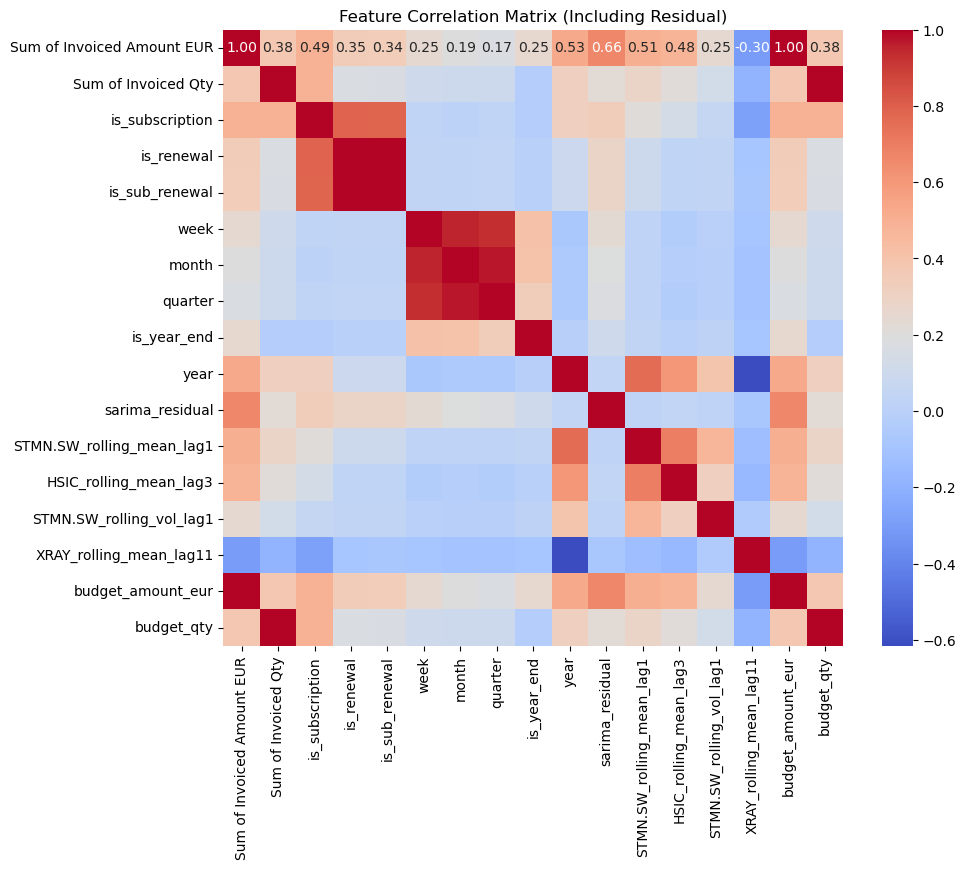

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_correlation(df, title="Feature Correlation Matrix (Including Residual)"):
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title)
    plt.show()


In [ ]:
def inspect_features(df, target_col='sarima_residual'):
    corr_with_target = df.corr(numeric_only=True)[target_col].sort_values(ascending=False)
    print("Correlation with target:")
    print(corr_with_target, "\n")

    unique_counts = df.nunique().sort_values()
    print("Unique value counts per column:")
    print(unique_counts, "\n")

    print("First few rows of data:")
    print(df.head())


sarima_residual               1.000000
Sum of Invoiced Amount EUR    0.661994
budget_amount_eur             0.661994
is_subscription               0.337074
is_renewal                    0.286442
is_sub_renewal                0.282854
week                          0.235778
Sum of Invoiced Qty           0.228643
budget_qty                    0.228643
month                         0.187573
quarter                       0.173525
is_year_end                   0.106516
year                          0.042882
HSIC_rolling_mean_lag3        0.041960
STMN.SW_rolling_vol_lag1      0.026394
STMN.SW_rolling_mean_lag1     0.025841
XRAY_rolling_mean_lag11      -0.081155
Name: sarima_residual, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def scale_features(df, target_col='sarima_residual'):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

    return X_scaled_df, y, scaler


In [ ]:
import numpy as np

def create_lstm_sequences(X_scaled, y, timesteps=26):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X_scaled)):
        X_seq.append(X_scaled[i - timesteps:i])
        y_seq.append(y.iloc[i])
    return np.array(X_seq), np.array(y_seq)


C:\Users\danii\AppData\Local\Temp\ipykernel_16888\201363759.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_seq.append(y[i])                         # residual for the next week


In [ ]:
import numpy as np

def describe_lstm_data(X_seq, y_seq):
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    print("X_seq shape:", X_seq.shape)  # (samples, timesteps, features)
    print("y_seq shape:", y_seq.shape)  # (samples,)
    return X_seq, y_seq


In [ ]:
def split_lstm_data(X, y, train_ratio=0.8):
    split_idx = int(len(X) * train_ratio)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    return X_train, X_test, y_train, y_test


In [ ]:
def describe_train_test_split(X_train, X_test, y_train, y_test):
    print("Train X shape:", X_train.shape)
    print("Test X shape:", X_test.shape)
    print("Train y shape:", y_train.shape)
    print("Test y shape:", y_test.shape)


Train X shape: (304, 26, 16)
Test X shape: (77, 26, 16)
Train y shape: (304,)
Test y shape: (77,)


In [ ]:
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Dropout
from keras.api.optimizers import Adam

def build_lstm_model(input_shape, lstm_units=64, dense_units=32, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))  # regression output

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    model.summary()
    return model


C:\Users\danii\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,849 (89.25 KB)

 Trainable params: 22,849 (89.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
param_grid = {
    'lstm_units': [32, 64],
    'dense_units': [16, 32],
    'dropout_rate': [0.1, 0.2],
    'learning_rate': [0.001, 0.0005]
}



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def grid_search_lstm(X_train, y_train, X_test, y_test, param_grid, epochs=100, batch_size=32):
    results = []

    for lstm_units in param_grid['lstm_units']:
        for dense_units in param_grid['dense_units']:
            for dropout_rate in param_grid['dropout_rate']:
                for lr in param_grid['learning_rate']:

                    model = Sequential()
                    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
                    model.add(Dropout(dropout_rate))
                    model.add(Dense(dense_units, activation='relu'))
                    model.add(Dense(1))

                    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])

                    history = model.fit(
                        X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
                        verbose=0
                    )

                    loss, mae = model.evaluate(X_test, y_test, verbose=0)

                    results.append({
                        'lstm_units': lstm_units,
                        'dense_units': dense_units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': lr,
                        'val_mae': min(history.history['val_mae']),
                        'test_mae': mae
                    })

                    print(f"Trained config: LSTM={lstm_units}, Dense={dense_units}, Dropout={dropout_rate}, LR={lr} → Test MAE={mae:.4f}")
    
    return results


Trained config: LSTM=32, Dense=16, Dropout=0.1, LR=0.001 → Test MAE=2512696.2500
Trained config: LSTM=32, Dense=16, Dropout=0.1, LR=0.0005 → Test MAE=2512696.2500
Trained config: LSTM=32, Dense=16, Dropout=0.2, LR=0.001 → Test MAE=2512696.2500
Trained config: LSTM=32, Dense=16, Dropout=0.2, LR=0.0005 → Test MAE=2512696.2500
Trained config: LSTM=32, Dense=32, Dropout=0.1, LR=0.001 → Test MAE=2512696.2500
Trained config: LSTM=32, Dense=32, Dropout=0.1, LR=0.0005 → Test MAE=2512696.2500
Trained config: LSTM=32, Dense=32, Dropout=0.2, LR=0.001 → Test MAE=2512696.2500
Trained config: LSTM=32, Dense=32, Dropout=0.2, LR=0.0005 → Test MAE=2512696.2500
Trained config: LSTM=64, Dense=16, Dropout=0.1, LR=0.001 → Test MAE=2512696.2500
Trained config: LSTM=64, Dense=16, Dropout=0.1, LR=0.0005 → Test MAE=2512696.2500
Trained config: LSTM=64, Dense=16, Dropout=0.2, LR=0.001 → Test MAE=2512696.2500
Trained config: LSTM=64, Dense=16, Dropout=0.2, LR=0.0005 → Test MAE=2512696.2500
Trained config: LSTM=6

KeyboardInterrupt: 

In [ ]:
import pandas as pd

def summarize_lstm_grid_results(results, sort_by='test_mae', top_n=5):
    results_df = pd.DataFrame(results)
    top_results = results_df.sort_values(by=sort_by).head(top_n)
    print(top_results)
    return top_results


   lstm_units  dense_units  dropout_rate  learning_rate     val_mae  \
0          32           16           0.1         0.0010  2130298.00   
2          32           16           0.2         0.0010  2130298.00   
4          32           32           0.1         0.0010  2130297.75   
5          32           32           0.1         0.0005  2130298.00   
6          32           32           0.2         0.0010  2130298.00   

     test_mae  
0  2512696.25  
2  2512696.25  
4  2512696.25  
5  2512696.25  
6  2512696.25  


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step


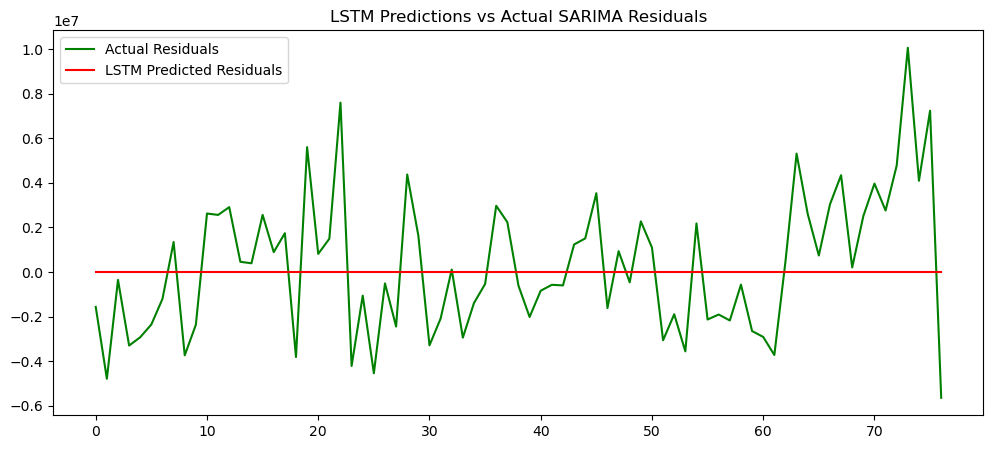

In [ ]:
import matplotlib.pyplot as plt

def plot_lstm_predictions(y_true, y_pred, title="LSTM Predictions vs Actual SARIMA Residuals"):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label='Actual Residuals', color='green')
    plt.plot(y_pred.flatten(), label='LSTM Predicted Residuals', color='red')
    plt.title(title)
    plt.legend()
    plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_target_series(y_train, y_test):
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1)).flatten()
    y_test_scaled = scaler.transform(np.array(y_test).reshape(-1, 1)).flatten()
    return y_train_scaled, y_test_scaled, scaler


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_target_minmax(y_train, y_test, feature_range=(-1, 1)):
    scaler = MinMaxScaler(feature_range=feature_range)
    y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1)).flatten()
    y_test_scaled = scaler.transform(np.array(y_test).reshape(-1, 1)).flatten()
    return y_train_scaled, y_test_scaled, scaler


In [ ]:
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Dropout, Bidirectional
from keras.api.optimizers import Adam
from keras.api.callbacks import EarlyStopping
from keras.api.losses import Huber

def build_and_train_bilstm_model(X_train, y_train_scaled, input_shape, learning_rate=0.008, epochs=100, batch_size=32):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=Huber(), metrics=['mae'])

    history = model.fit(
        X_train, y_train_scaled,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )

    return model, history


C:\Users\danii\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 482ms/step - loss: 0.1119 - mae: 0.3495 - val_loss: 0.0895 - val_mae: 0.3498
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0496 - mae: 0.2412 - val_loss: 0.0869 - val_mae: 0.3413
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0424 - mae: 0.2220 - val_loss: 0.0879 - val_mae: 0.3441
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0415 - mae: 0.2260 - val_loss: 0.0879 - val_mae: 0.3431
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0426 - mae: 0.2215 - val_loss: 0.0896 - val_mae: 0.3523
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0398 - mae: 0.2258 - val_loss: 0.0891 - val_mae: 0.3521
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0381 - mae: 0.2127 - val_loss: 0.0872 - val_mae: 0.3506
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0455 - mae: 0.2384 - val_loss: 0.0891 - val_mae: 0.3527
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.042

In [ ]:
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Dropout
from keras.api.optimizers import Adam
from keras.api.callbacks import EarlyStopping

def build_and_train_stacked_lstm(X_train, y_train_scaled, input_shape, learning_rate=0.008, epochs=100, batch_size=32):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train_scaled,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )

    return model, history


C:\Users\danii\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - loss: 0.1442 - mae: 0.3057 - val_loss: 0.1827 - val_mae: 0.3511
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0998 - mae: 0.2406 - val_loss: 0.1855 - val_mae: 0.3409
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0976 - mae: 0.2421 - val_loss: 0.1803 - val_mae: 0.3499
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0815 - mae: 0.2235 - val_loss: 0.1754 - val_mae: 0.3436
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0816 - mae: 0.2243 - val_loss: 0.1752 - val_mae: 0.3432
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0804 - mae: 0.2250 - val_loss: 0.1754 - val_mae: 0.3442
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0772 - mae: 0.2153 - val_loss: 0.1757 - val_mae: 0.3468
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0849 - mae: 0.2241 - val_loss: 0.1739 - val_mae: 0.3451
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0868 - mae

In [ ]:
def inverse_scale_predictions(y_pred_scaled, scaler):
    return scaler.inverse_transform(y_pred_scaled)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 615ms/step


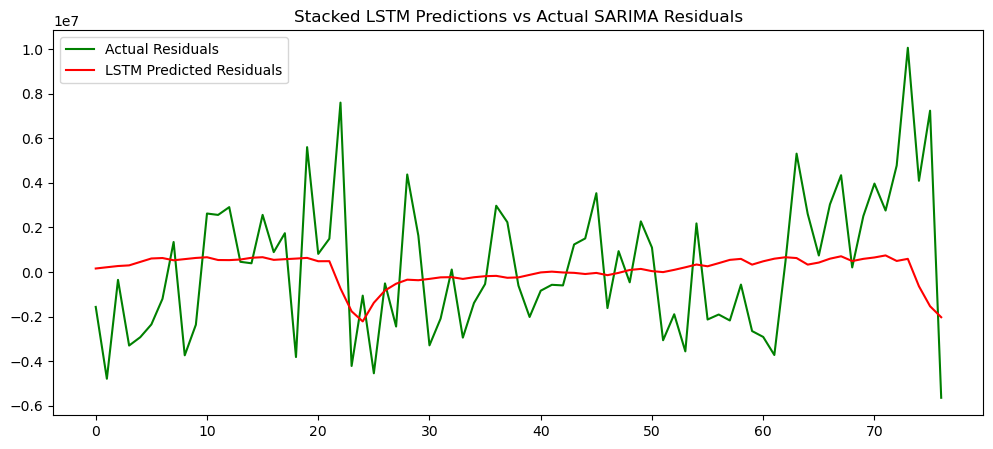

In [ ]:
import matplotlib.pyplot as plt

def plot_lstm_residual_comparison(y_true, y_pred, title="Stacked LSTM Predictions vs Actual SARIMA Residuals"):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label='Actual Residuals', color='green')
    plt.plot(y_pred.flatten(), label='LSTM Predicted Residuals', color='red')
    plt.title(title)
    plt.legend()
    plt.show()


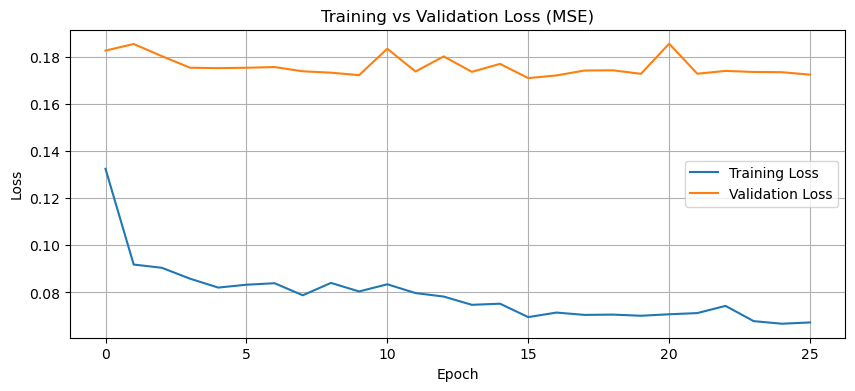

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, title='Training vs Validation Loss (MSE)'):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


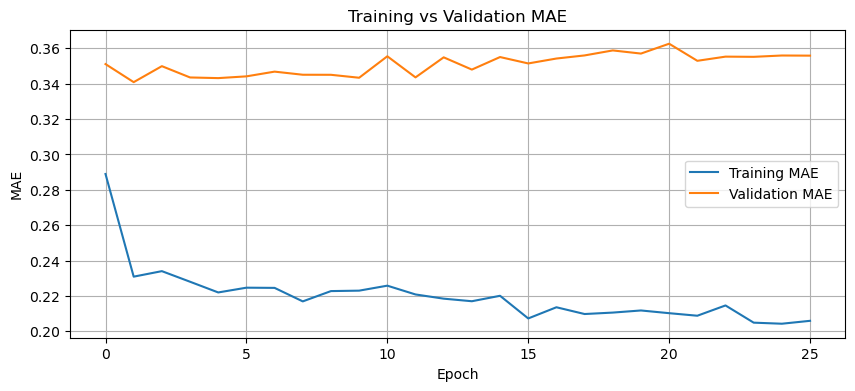

In [ ]:
import matplotlib.pyplot as plt

def plot_training_mae(history, title='Training vs Validation MAE'):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()


Sales prediciton LSTM


In [ ]:
sarima_model = fit_sarima(
    weekly_agg['Sum of Invoiced Amount EUR'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 13)
)


In [ ]:
def forecast_from_index(sarima_model, start_index):
    prediction = sarima_model.get_prediction(start=start_index)
    return prediction.predicted_mean


In [ ]:
def add_sarima_forecast_to_combined(combined_df, sarima_forecast_series, timesteps):
    combined = combined_df.iloc[timesteps:]  # align to LSTM sequence start
    sarima_aligned = sarima_forecast_series.reindex(combined.index).fillna(0)
    combined['sarima_forecast'] = sarima_aligned
    return combined


C:\Users\danii\AppData\Local\Temp\ipykernel_16888\976409227.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['sarima_forecast'] = sarima_forecast


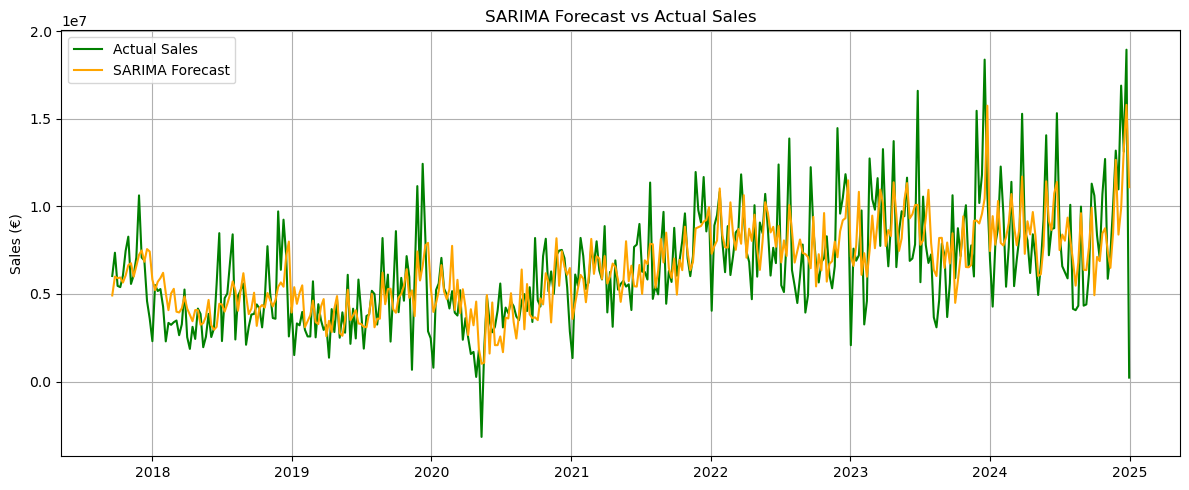

In [ ]:
def plot_sarima_vs_actual(actual, forecast, title="SARIMA Forecast vs Actual Sales"):
    plt.figure(figsize=(12, 5))
    plt.plot(actual, label='Actual Sales', color='green')
    plt.plot(forecast, label='SARIMA Forecast', color='orange')
    plt.title(title)
    plt.ylabel("Sales (€)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def add_temporal_and_error_features(df):
    df['sales_std_4w'] = df['Sum of Invoiced Amount EUR'].rolling(4).std().fillna(0)
    df['sales_delta_1w'] = df['Sum of Invoiced Amount EUR'].diff().fillna(0)
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    df['sarima_residual'] = df['Sum of Invoiced Amount EUR'] - df['sarima_forecast']
    return df


In [ ]:
def prepare_hybrid_model_data(combined_df, target_col='Sum of Invoiced Amount EUR', sarima_forecast_series=None):
    y = combined_df[target_col].values
    X = combined_df.drop(columns=[target_col]).copy()
    if sarima_forecast_series is not None:
        X['sarima_forecast'] = sarima_forecast_series.reindex(X.index).fillna(0)
    return X, y


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_features_and_target(X, y, feature_range=(0, 1)):
    feature_scaler = MinMaxScaler()
    X_scaled = feature_scaler.fit_transform(X)

    target_scaler = MinMaxScaler(feature_range=feature_range)
    y_scaled = target_scaler.fit_transform(np.array(y).reshape(-1, 1)).flatten()

    return X_scaled, y_scaled, feature_scaler, target_scaler


In [ ]:
# 1. Load SARIMA residuals
residual_series = load_residuals("Working_df/residuals.csv")

# Load full actuals dataset used for SARIMA + feature creation
df = pd.read_csv("Working_df/Actuals_all_enriched.csv")
df['week_start'] = pd.to_datetime(df['week_start'])

# 2. Load budget data
budget_weekly = load_weekly_budget('Working_df/Budget_all.csv')

# 3. Create weekly features with residuals
weekly_features = create_weekly_features(df, residual_series)
weekly_features = add_residual_lags(weekly_features, base_col='residual', lags=[1, 2, 3])

# 4. Plot SARIMA residual series and distribution
plot_residual_series(residual_series)
plot_residual_distribution(residual_series)
plot_residual_acf(residual_series, lags=30)

# 5. Load competitor stock features
stock_df = load_weekly_competitor_features("Working_df/Selected_lagged_features.csv")

# 6. Create aggregated calendar/sales features
weekly_agg = create_weekly_calendar_features(df)

# 7. Merge residuals and stock features
combined = combine_features_with_residuals(weekly_agg, residual_series, stock_df)

# 8. Add budget features
combined = add_budget_features(combined, budget_weekly)

# 9. Explore correlation
plot_feature_correlation(combined)
inspect_features(combined, target_col='sarima_residual')

# 10. Scale features and residual target
X_scaled_df, y, _ = scale_features(combined, target_col='sarima_residual')

# 11. Format LSTM input sequences
X_seq, y_seq = create_lstm_sequences(X_scaled_df, y, timesteps=26)
X_seq, y_seq = describe_lstm_data(X_seq, y_seq)

# 12. Split train/test
X_train, X_test, y_train, y_test = split_lstm_data(X_seq, y_seq, train_ratio=0.8)
describe_train_test_split(X_train, X_test, y_train, y_test)

# 13. Build and train LSTM model
model, history = build_and_train_stacked_lstm(
    X_train, y_train,
    input_shape=(X_train.shape[1], X_train.shape[2])
)

# 14. Predict and compare
y_pred = model.predict(X_test)
plot_lstm_predictions(y_test, y_pred)
plot_training_history(history)
plot_training_mae(history)

# 15. Fit full SARIMA model
sarima_model = fit_sarima(
    weekly_agg['Sum of Invoiced Amount EUR'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 13)
)

# 16. Forecast with SARIMA from LSTM-ready point onward
sarima_forecast_series = forecast_from_index(sarima_model, start_index=weekly_agg.index[26])

# 17. Align SARIMA with combined data
combined = add_sarima_forecast_to_combined(combined, sarima_forecast_series, timesteps=26)
plot_sarima_vs_actual(combined['Sum of Invoiced Amount EUR'], combined['sarima_forecast'])

# 18. Add derived time/error features
combined = add_temporal_and_error_features(combined)

# 19. Prepare inputs and target for hybrid sales forecasting
X, y = prepare_hybrid_model_data(combined, target_col='Sum of Invoiced Amount EUR', sarima_forecast_series=sarima_forecast_series)

# 20. Scale hybrid model data
X_scaled, y_scaled, feature_scaler, target_scaler = scale_features_and_target(X, y, feature_range=(0, 1))

# 21. Sequence hybrid inputs
X_seq, y_seq = create_lstm_sequences(X_scaled, y_scaled, timesteps=8)
X_train, X_test, y_train, y_test = split_lstm_data(X_seq, y_seq, train_ratio=0.8)

# 22. Train hybrid LSTM model
model, history = build_and_train_stacked_lstm(
    X_train, y_train,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    learning_rate=0.008
)

# 23. Predict and inverse scale
y_pred = model.predict(X_test)
y_pred_inv = inverse_scale_predictions(y_pred, target_scaler)
y_test_inv = inverse_scale_predictions(y_test.reshape(-1, 1), target_scaler)

# 24. Plot hybrid forecast vs actual
plot_lstm_residual_comparison(y_test_inv, y_pred_inv, title="LSTM Forecast vs Actual Sales")
plot_training_history(history)
plot_training_mae(history)


Trying on residuals again

In [ ]:
y = combined['Sum of Invoiced Amount EUR'] - combined['sarima_forecast']


In [ ]:
from sklearn.preprocessing import MinMaxScaler

target_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()


In [ ]:
X = combined.drop(columns=['Sum of Invoiced Amount EUR'])


In [ ]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)


In [ ]:
timesteps = 8
X_seq, y_seq = [], []

for i in range(timesteps, len(X_scaled)):
    X_seq.append(X_scaled[i - timesteps:i])
    y_seq.append(y_scaled[i])

import numpy as np
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)


In [ ]:
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]


In [ ]:
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Dropout
from keras.api.optimizers import Adam
from keras.api.callbacks import EarlyStopping
from keras.api.losses import Huber

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.008), loss=Huber(), metrics=['mae'])

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)


C:\Users\danii\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - loss: 0.0365 - mae: 0.2140 - val_loss: 0.0447 - val_mae: 0.2528
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0217 - mae: 0.1572 - val_loss: 0.0428 - val_mae: 0.2435
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0165 - mae: 0.1356 - val_loss: 0.0428 - val_mae: 0.2458
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0212 - mae: 0.1577 - val_loss: 0.0425 - val_mae: 0.2417
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0183 - mae: 0.1496 - val_loss: 0.0429 - val_mae: 0.2466
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0176 - mae: 0.1409 - val_loss: 0.0424 - val_mae: 0.2447
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0189 - mae: 0.1455 - val_loss: 0.0424 - val_mae: 0.2429
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0206 - mae: 0.1563 - val_loss: 0.0424 - val_mae: 0.2454
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0185 - 

In [ ]:
# Predict residuals
y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)

# Get SARIMA forecast for same period
sarima_part = combined['sarima_forecast'].iloc[-len(y_pred):].values.reshape(-1, 1)

# Final forecast = base + correction
final_forecast = y_pred_inv + sarima_part


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001537AB81820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


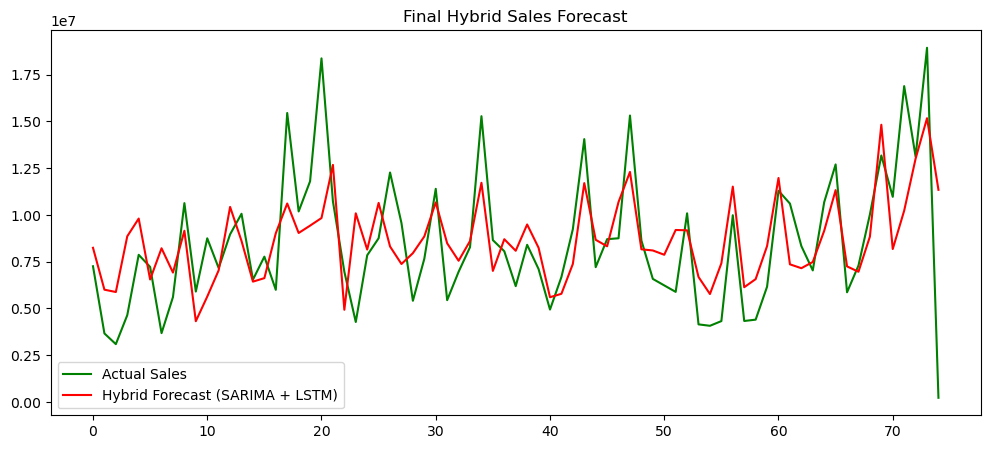

In [ ]:
true_sales = combined['Sum of Invoiced Amount EUR'].iloc[-len(y_pred):].values

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(true_sales, label='Actual Sales', color='green')
plt.plot(final_forecast, label='Hybrid Forecast (SARIMA + LSTM)', color='red')
plt.title("Final Hybrid Sales Forecast")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(true_sales, final_forecast)
rmse = np.sqrt(mean_squared_error(true_sales, final_forecast))
mape = np.mean(np.abs((true_sales - final_forecast.flatten()) / true_sales)) * 100

print(f"Hybrid Forecast MAE: {mae:,.2f}")
print(f"Hybrid Forecast RMSE: {rmse:,.2f}")
print(f"Hybrid Forecast MAPE: {mape:.2f}%")


Hybrid Forecast MAE: 2,114,406.32
Hybrid Forecast RMSE: 2,794,996.37
Hybrid Forecast MAPE: 92.71%


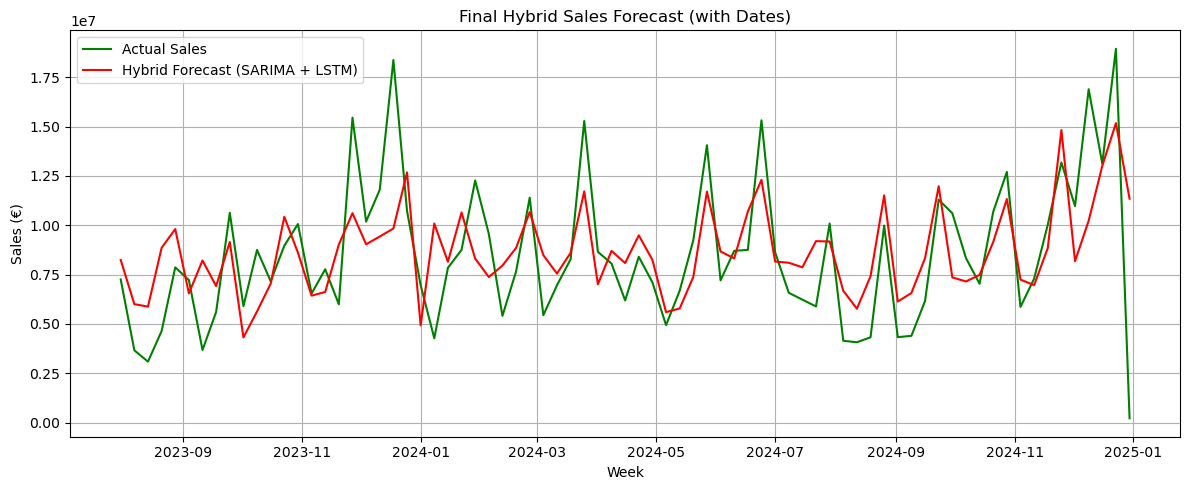

In [ ]:
dates = combined.index[-len(final_forecast):]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(dates, true_sales, label='Actual Sales', color='green')
plt.plot(dates, final_forecast, label='Hybrid Forecast (SARIMA + LSTM)', color='red')
plt.title("Final Hybrid Sales Forecast (with Dates)")
plt.xlabel("Week")
plt.ylabel("Sales (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


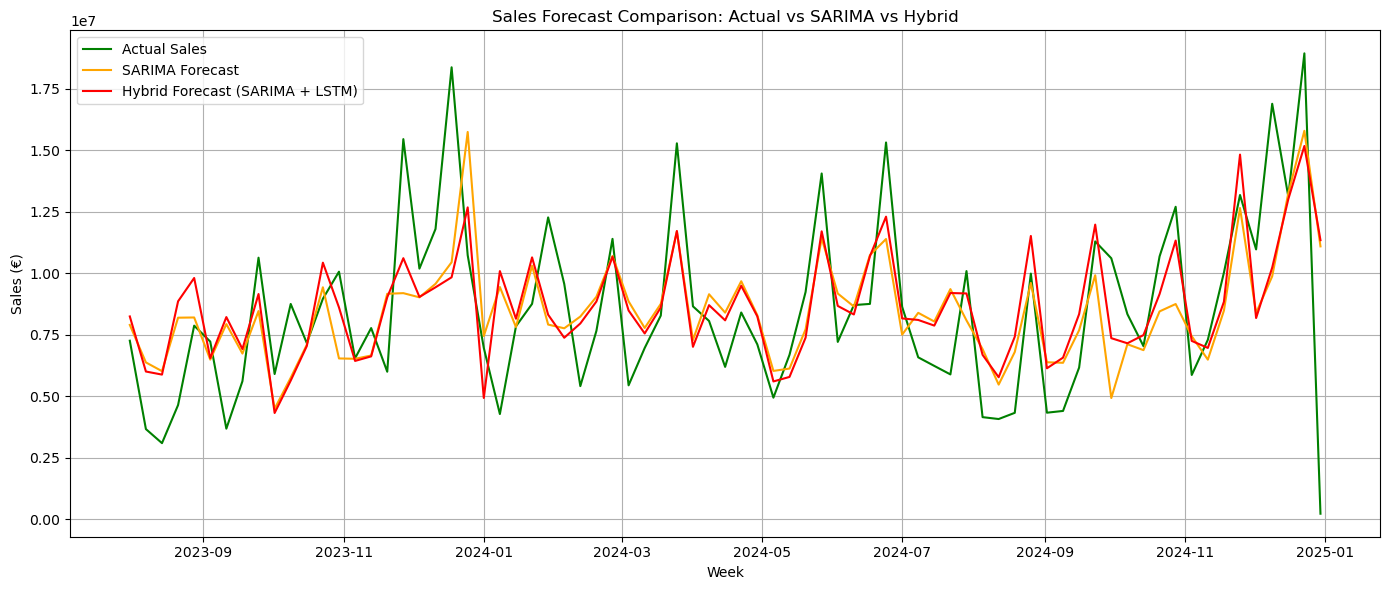

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(dates, true_sales, label='Actual Sales', color='green')
plt.plot(dates, sarima_forecast[-len(true_sales):], label='SARIMA Forecast', color='orange')
plt.plot(dates, final_forecast, label='Hybrid Forecast (SARIMA + LSTM)', color='red')
plt.title("Sales Forecast Comparison: Actual vs SARIMA vs Hybrid")
plt.xlabel("Week")
plt.ylabel("Sales (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecasts(true, forecast_dict):
    results = {}
    
    for label, pred in forecast_dict.items():
        mae = mean_absolute_error(true, pred)
        rmse = np.sqrt(mean_squared_error(true, pred))
        mape = np.mean(np.abs((true - pred.flatten()) / true)) * 100
        results[label] = {'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape}
    
    return results


In [ ]:
def evaluate_forecasts(true, forecast_dict):
    results = {}
    
    true = np.array(true).flatten()  # ensure it's an array
    
    for label, pred in forecast_dict.items():
        pred = np.array(pred).flatten()  # ensure prediction is array
        
        mae = mean_absolute_error(true, pred)
        rmse = np.sqrt(mean_squared_error(true, pred))
        mape = np.mean(np.abs((true - pred) / true)) * 100
        results[label] = {'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape}
    
    return results


In [ ]:
forecast_dict = {
    'SARIMA': sarima_forecast[-len(true_sales):],
    'Hybrid': final_forecast
}

results = evaluate_forecasts(true_sales, forecast_dict)

# Print nicely
for model, metrics in results.items():
    print(f"\n{model} Forecast:")
    for k, v in metrics.items():
        print(f"  {k}: {v:,.2f}")

# Optional: compare improvement
improvement = (
    (results['SARIMA']['RMSE'] - results['Hybrid']['RMSE']) / results['SARIMA']['RMSE'] * 100
)
print(f"\nHybrid RMSE improvement over SARIMA: {improvement:.2f}%")



SARIMA Forecast:
  MAE: 2,224,410.00
  RMSE: 2,944,548.28
  MAPE (%): 91.89

Hybrid Forecast:
  MAE: 2,114,406.32
  RMSE: 2,794,996.37
  MAPE (%): 92.71

Hybrid RMSE improvement over SARIMA: 5.08%
